In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG16 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling=None)

In [7]:
print("Extracting features from VGG16 layers ...")
bnfeatures = base_model.predict(X)

Extracting features from VGG16 layers ...


In [8]:
print(bnfeatures)

[[[[  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   ..., 
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           5.84151363
      0.        ]]

  [[  0.           0.           0.         ...,   0.           0.           0.        ]
   [  0.           0.           0.         ...,   0.           0.
      4.76972342]
   [  0.           0.           0.         ...,   0.           0.
      0.65717864]
   ..., 
   [  0.           0.           0.         ...,   3.30723596   0.
     11.74923515]
   [  0.           0.           0.         ...,   0.           0.
      7.57518339]
   [  0.           0.   

In [9]:
bnfeatures.shape

(9339, 7, 7, 512)

In [10]:
# Adding a custom top layer to the model
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
x = Flatten(name='flatten')(bottleneck_features)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 25)                102425    
Total params: 119,648,281
Trainable params: 119,648,281
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-vgg16-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_fc1_weights = top_model.layers[-3].get_weights()
    pretrained_fc2_weights = top_model.layers[-2].get_weights()
    pretrained_top_weights = top_model.layers[-1].get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-3].set_weights(pretrained_fc1_weights)
    model.layers[-2].set_weights(pretrained_fc2_weights)
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.2032
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 10s - loss: 15.6678 - acc: 0.0260 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 2/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 3/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 4/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 5/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 6/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 7/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.777

8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 64/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 65/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 66/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 67/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 68/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 69/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 70/100
8394/8394 [==============================] - 7s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770

8394/8394 [==============================] - 94s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 26/100
8394/8394 [==============================] - 96s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 27/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 28/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 29/100
8394/8394 [==============================] - 94s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 30/100
8394/8394 [==============================] - 94s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 31/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 32/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss:

8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 89/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 90/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 91/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 92/100
8394/8394 [==============================] - 94s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 93/100
8394/8394 [==============================] - 94s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 94/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss: 15.7770 - val_acc: 0.0212
Epoch 95/100
8394/8394 [==============================] - 95s - loss: 15.7725 - acc: 0.0214 - val_loss:

8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 51/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 52/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 53/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 54/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 55/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 56/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 57/100
8397/8397 [==============================] - 7s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705

8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 13/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 14/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 15/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 16/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 17/100
8397/8397 [==============================] - 93s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 18/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 19/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss:

8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 76/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 77/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 78/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 79/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 80/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 81/100
8397/8397 [==============================] - 93s - loss: 11.0237 - acc: 0.3161 - val_loss: 11.0705 - val_acc: 0.3132
Epoch 82/100
8397/8397 [==============================] - 94s - loss: 11.0237 - acc: 0.3161 - val_loss:

8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 38/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 39/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 40/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 41/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 42/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 43/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 44/100
8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490

8401/8401 [==============================] - 7s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
[2] Pre-trained acurracy (top_model): 0.3145
[2] Fine-tuning the model ...
Train on 8401 samples, validate on 938 samples
Epoch 1/100
8401/8401 [==============================] - 96s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 2/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 3/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 4/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 5/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 6/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_

8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 63/100
8401/8401 [==============================] - 92s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 64/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 65/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 66/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 67/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 68/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 69/100
8401/8401 [==============================] - 93s - loss: 11.0262 - acc: 0.3159 - val_loss:

8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 25/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 26/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 27/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 28/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 29/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 30/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 31/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381

8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 88/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 89/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 90/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 91/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 92/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 93/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 94/100
8403/8403 [==============================] - 7s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381

8403/8403 [==============================] - 93s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 50/100
8403/8403 [==============================] - 92s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 51/100
8403/8403 [==============================] - 93s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 52/100
8403/8403 [==============================] - 93s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 53/100
8403/8403 [==============================] - 92s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 54/100
8403/8403 [==============================] - 93s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 55/100
8403/8403 [==============================] - 92s - loss: 11.0274 - acc: 0.3158 - val_loss: 11.0381 - val_acc: 0.3152
Epoch 56/100
8403/8403 [==============================] - 92s - loss: 11.0274 - acc: 0.3158 - val_loss:

8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 12/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 13/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 14/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 15/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 16/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 17/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 18/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327

8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 75/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 76/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 77/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 78/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 79/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 80/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 81/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327

8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 37/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 38/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 39/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 40/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 41/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 42/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 43/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss:

8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 100/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
[4] Test acurracy: 0.3155 (9353.5150 s)
[5] Pre-training the top model ...
[5] Initial acurracy (top_model): 0.2064
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 7s - loss: 11.0085 - acc: 0.3138 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 2/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 3/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 4/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 5/100
8404/8404 [==============================] - 7s - loss: 11.0280 -

8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 62/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 63/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 64/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 65/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 66/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 67/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 68/100
8404/8404 [==============================] - 7s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327

8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 24/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 25/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 26/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 27/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 28/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 29/100
8404/8404 [==============================] - 92s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 30/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss:

8404/8404 [==============================] - 92s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 87/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 88/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 89/100
8404/8404 [==============================] - 92s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 90/100
8404/8404 [==============================] - 92s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 91/100
8404/8404 [==============================] - 92s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 92/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 93/100
8404/8404 [==============================] - 93s - loss: 11.0280 - acc: 0.3158 - val_loss:

Epoch 48/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 49/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 50/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 51/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 52/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 53/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 54/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 55/100
8408/8408 [==============================] - 7s - loss: 11.0304 - acc: 0.3157 - val_

8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 11/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 12/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 13/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 14/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 15/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 16/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 17/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss:

8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 74/100
8408/8408 [==============================] - 93s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 75/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 76/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 77/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 78/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 79/100
8408/8408 [==============================] - 94s - loss: 11.0304 - acc: 0.3157 - val_loss: 11.0109 - val_acc: 0.3169
Epoch 80/100
8408/8408 [==============================] - 93s - loss: 11.0304 - acc: 0.3157 - val_loss:

8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 36/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 37/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 38/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 39/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 40/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 41/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 42/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999

8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 99/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 100/100
8410/8410 [==============================] - 7s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
[7] Pre-trained acurracy (top_model): 0.3175
[7] Fine-tuning the model ...
Train on 8410 samples, validate on 929 samples
Epoch 1/100
8410/8410 [==============================] - 95s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 2/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 3/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 4/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val

8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 61/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 62/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 63/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 64/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 65/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 66/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 67/100
8410/8410 [==============================] - 93s - loss: 11.0316 - acc: 0.3156 - val_loss:

8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 23/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 24/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 25/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 26/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 27/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 28/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 29/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777

8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 86/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 87/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 88/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 89/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 90/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 91/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 92/100
8414/8414 [==============================] - 7s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777

8414/8414 [==============================] - 95s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 48/100
8414/8414 [==============================] - 94s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 49/100
8414/8414 [==============================] - 94s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 50/100
8414/8414 [==============================] - 94s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 51/100
8414/8414 [==============================] - 95s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 52/100
8414/8414 [==============================] - 94s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 53/100
8414/8414 [==============================] - 94s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 54/100
8414/8414 [==============================] - 94s - loss: 11.0340 - acc: 0.3154 - val_loss:

8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 9/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 10/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 11/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 12/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 13/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 14/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 15/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 

8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 72/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 73/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 74/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 75/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 76/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 77/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 78/100
8416/8416 [==============================] - 7s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841

8416/8416 [==============================] - 95s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 34/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 35/100
8416/8416 [==============================] - 95s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 36/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 37/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 38/100
8416/8416 [==============================] - 95s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 39/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 40/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss:

8416/8416 [==============================] - 95s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 97/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 98/100
8416/8416 [==============================] - 96s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 99/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 100/100
8416/8416 [==============================] - 94s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
[9] Test acurracy: 0.3185 (9490.9642 s)


In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.2863


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

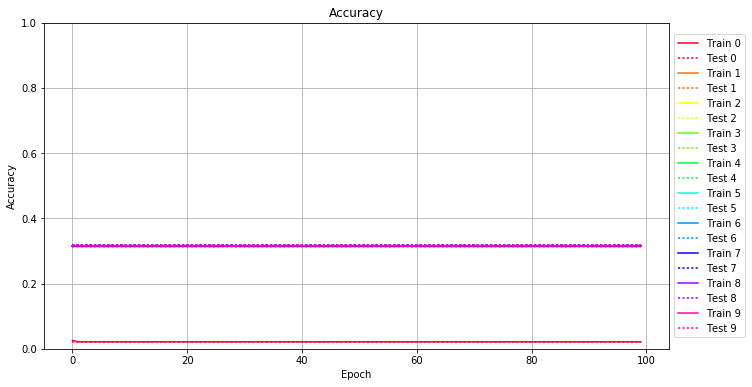

In [17]:
plot_acc(tophistory)

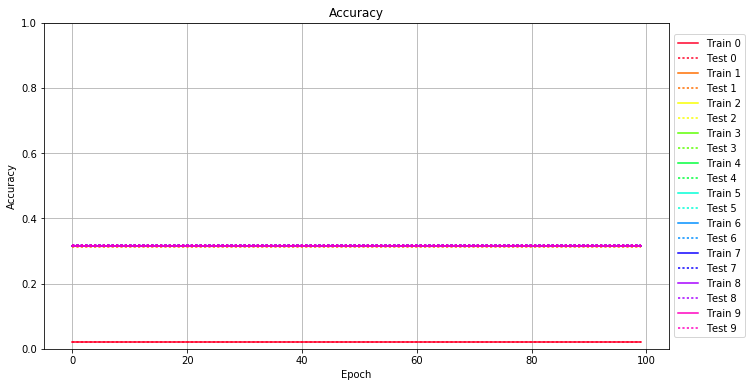

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

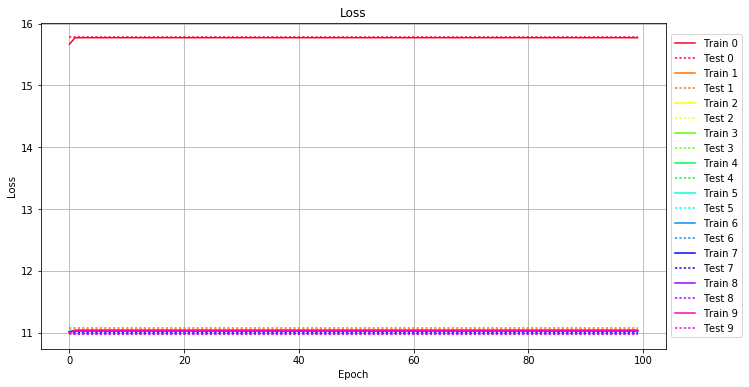

In [20]:
plot_loss(tophistory)

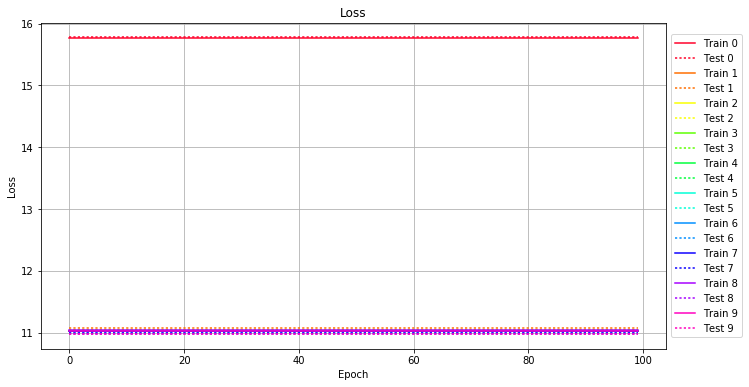

In [21]:
plot_loss(history)

Plotting the confusion matrix


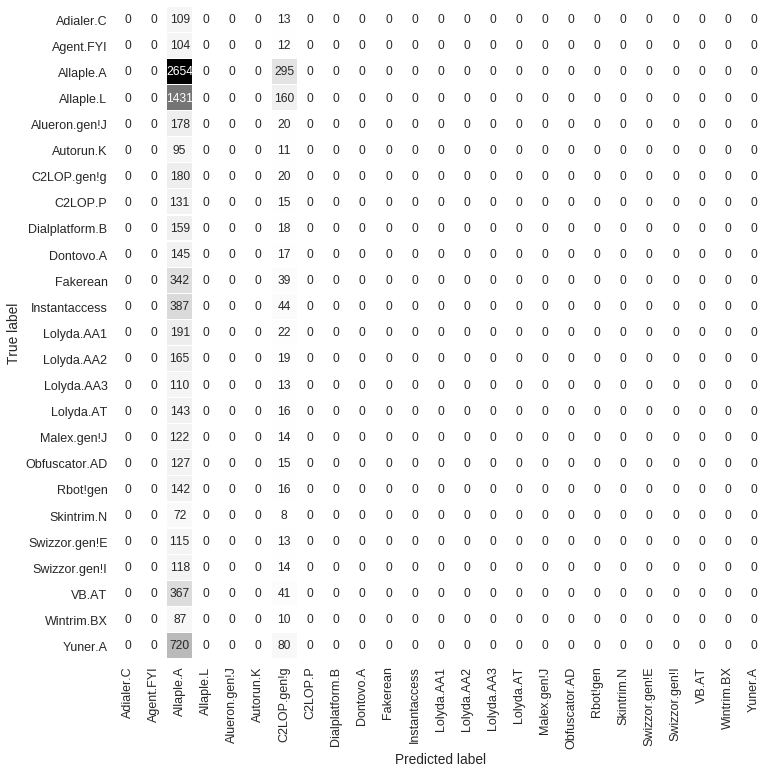

In [22]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


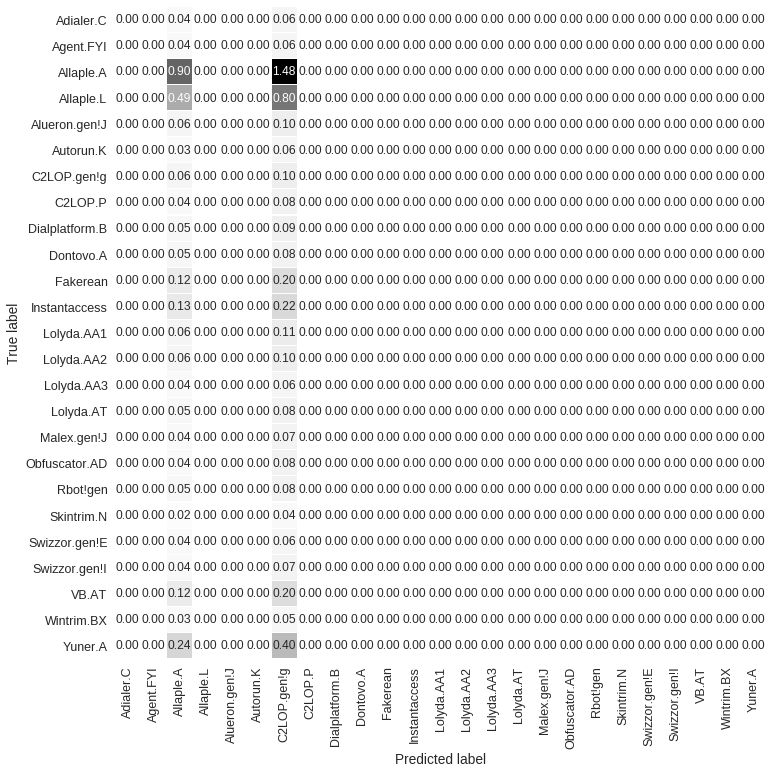

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.025970931617822254, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888495330275, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888495330275, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0

In [25]:
for h in history:
    print(h.history)

{'acc': [0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888495330275, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888495330275, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

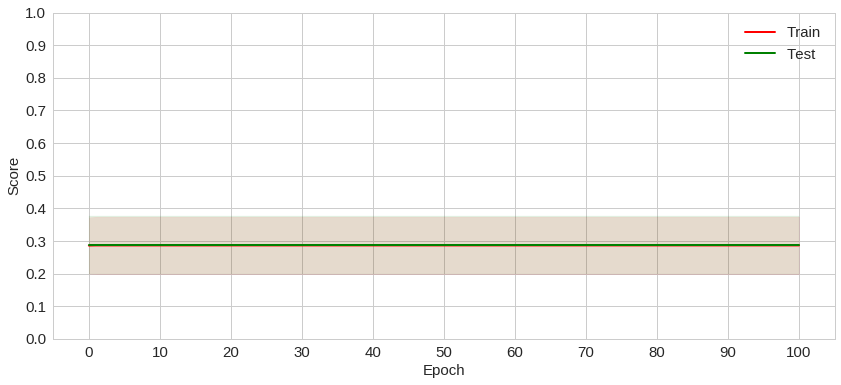

In [27]:
plot_mean_acc(tophistory)

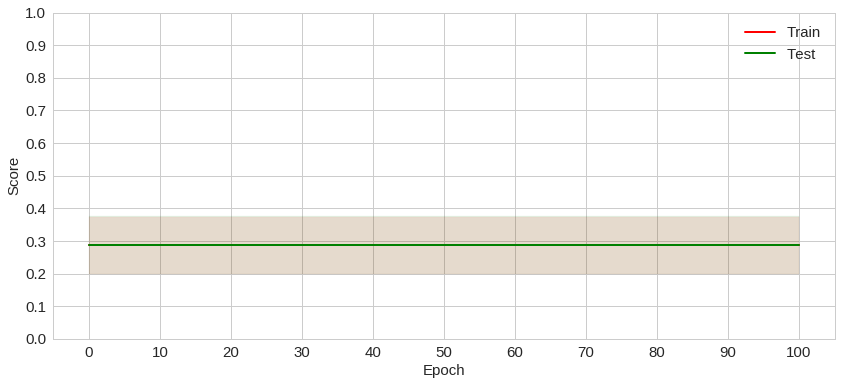

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

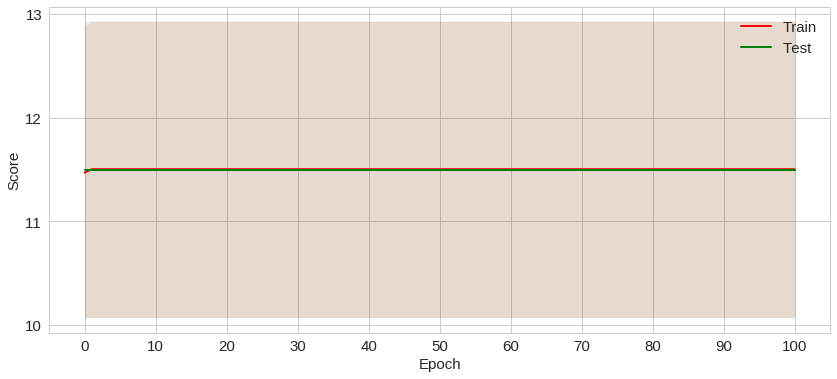

In [30]:
plot_mean_loss(tophistory)

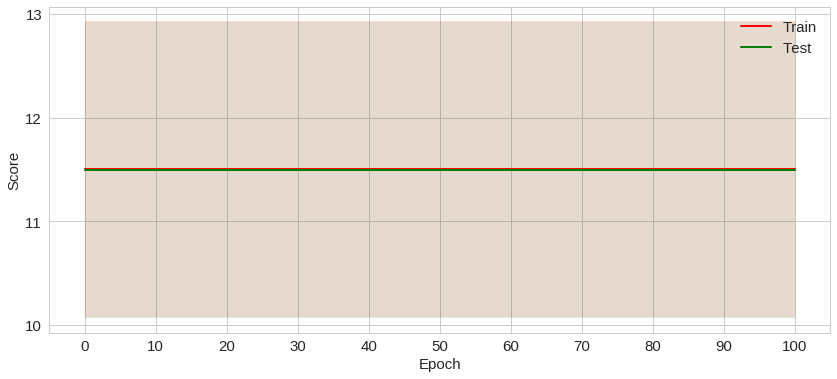

In [31]:
plot_mean_loss(history)

In [33]:
tophist = [{'acc': [0.025970931617822254, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888495330275, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888495330275, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888495330275, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844], 'loss': [15.667803508257736, 15.772460593931839, 15.77246063028826, 15.772460593931839, 15.772460617563512, 15.772460593931839, 15.772460610973912, 15.772460593931839, 15.772460615745691, 15.772460593931839, 15.772460623016975, 15.772460623016975, 15.772460595749662, 15.772460608474407, 15.772460593931839, 15.772460593931839, 15.772460595749662, 15.772460593931839, 15.772460615745691, 15.772460601203123, 15.772460608474407, 15.772460593931839, 15.772460601203123, 15.772460608474407, 15.772460623016975, 15.772460623016975, 15.772460603020946, 15.772460601203123, 15.772460601203123, 15.772460593931839, 15.772460603020946, 15.772460593931839, 15.772460601203123, 15.772460610973912, 15.772460593931839, 15.772460603020946, 15.772460608474407, 15.772460595749662, 15.772460608474407, 15.772460593931839, 15.772460615745691, 15.772460595749662, 15.772460601203123, 15.772460593931839, 15.772460601203123, 15.772460608474407, 15.772460603020946, 15.772460593931839, 15.772460608474407, 15.772460601203123, 15.772460601203123, 15.772460593931839, 15.772460615745691, 15.772460603020946, 15.772460608474407, 15.772460608474407, 15.772460601203123, 15.772460608474407, 15.772460603020946, 15.772460603020946, 15.772460608474407, 15.772460593931839, 15.772460593931839, 15.772460615745691, 15.772460610292228, 15.772460603020946, 15.772460615745691, 15.772460601203123, 15.772460637559544, 15.772460603020946, 15.772460593931839, 15.772460593931839, 15.772460608474407, 15.772460601203123, 15.772460608474407, 15.772460608474407, 15.772460608474407, 15.772460608474407, 15.772460624834796, 15.772460608474407, 15.772460615745691, 15.772460593931839, 15.772460608474407, 15.772460601203123, 15.772460617563512, 15.772460623016975, 15.772460601203123, 15.772460608474407, 15.772460593931839, 15.772460608474407, 15.772460623016975, 15.772460608474407, 15.772460610292228, 15.772460593931839, 15.772460601203123, 15.772460593931839, 15.772460617109058, 15.772460595749662, 15.772460601203123, 15.772460608474407], 'val_acc': [0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163], 'val_loss': [15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043]},
{'acc': [0.31463617961279222, 0.31606526142772612, 0.31606526141175489, 0.31606526141352947, 0.31606526140731844, 0.31606526142772612, 0.3160652614206278, 0.31606526140731844, 0.31606526142772612, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526144547192, 0.31606526141352947, 0.31606526142772612, 0.31606526145966857, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.3160652614206278, 0.31606526145966857, 0.3160652614206278, 0.31606526141175489, 0.31606526141352947, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526142772612, 0.31606526145257025, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526141352947, 0.31606526145257025, 0.31606526141175489, 0.31606526145966857, 0.31606526142772612, 0.3160652614206278, 0.31606526144547192, 0.31606526145966857, 0.31606526145966857, 0.31606526142772612, 0.31606526142772612, 0.31606526141175489, 0.31606526143127528, 0.3160652614206278, 0.31606526145966857, 0.31606526145257025, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.3160652614206278, 0.31606526144547192, 0.31606526145966857, 0.31606526145257025, 0.3160652614206278, 0.31606526142772612, 0.31606526145966857, 0.3160652614206278, 0.31606526145966857, 0.31606526153065184, 0.31606526140731844, 0.3160652614383736, 0.3160652614206278, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.31606526142772612, 0.31606526141175489, 0.3160652614206278, 0.3160652614206278, 0.31606526144547192, 0.3160652614206278, 0.31606526145257025, 0.31606526141175489, 0.31606526145257025, 0.31606526144547192, 0.3160652614206278, 0.31606526142772612, 0.31606526141175489, 0.31606526141175489, 0.3160652614206278, 0.31606526145966857, 0.31606526144547192, 0.31606526145966857, 0.31606526145966857, 0.31606526144547192, 0.31606526145966857, 0.31606526142772612, 0.31606526140731844, 0.31606526141175489, 0.31606526145966857, 0.3160652614206278, 0.31606526140288199, 0.31606526141352947, 0.3160652614206278, 0.31606526145966857, 0.31606526141175489, 0.31606526145966857, 0.3160652614206278], 'loss': [11.001319726024255, 11.023725345189535, 11.0237253521175, 11.023725281929252, 11.023725328494271, 11.023725305211761, 11.023725368812764, 11.02372535030033, 11.023725337920848, 11.023725308846105, 11.023725330652162, 11.023725317931962, 11.023725262281085, 11.023725340078739, 11.02372531611479, 11.023725318272682, 11.023725347006705, 11.023725288857218, 11.023725265233988, 11.023725325200648, 11.023725383690856, 11.023725288857218, 11.023725308505385, 11.023725318272682, 11.023725337920848, 11.023725294308733, 11.023725274319846, 11.023725334286505, 11.023725333150773, 11.023725330652162, 11.023725330652162, 11.023725397887508, 11.023725340078739, 11.023725362225518, 11.023725243087211, 11.023725390959541, 11.023725330652162, 11.023725317931962, 11.023725349505316, 11.023725332810054, 11.023725354616111, 11.023725279771361, 11.023725265233988, 11.023725286699326, 11.023725314581553, 11.023725310663275, 11.023725318272682, 11.023725340419459, 11.023725287040046, 11.023725330652162, 11.023725354275392, 11.023725376081449, 11.023725371311375, 11.02372530373531, 11.023725362225518, 11.023725281588531, 11.023725330652162, 11.023725369153484, 11.023725310663275, 11.023725325541367, 11.023725306233921, 11.023725357569015, 11.023725328039978, 11.023725347006705, 11.023725325200648, 11.023725288857218, 11.023725301577418, 11.023725345189535, 11.0237253521175, 11.023725343372362, 11.02372533973802, 11.023725327699259, 11.023725347006705, 11.023725304076029, 11.023725343372362, 11.023725362225518, 11.023725313161886, 11.023725347006705, 11.023725330652162, 11.023725314297618, 11.023725321566305, 11.023725325200648, 11.023725318272682, 11.023725349505316, 11.023725354616111, 11.023725318272682, 11.023725370573148, 11.02372530373531, 11.023725381532964, 11.0237253648377, 11.023725263416816, 11.023725394593884, 11.023725361544077, 11.023725320884866, 11.023725376422169, 11.023725361544077, 11.023725274660565, 11.023725323042756, 11.023725325541367, 11.023725288857218], 'val_acc': [0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086], 'val_loss': [11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856]},
{'acc': [0.31639090586937463, 0.31591477207577862, 0.315914772059815, 0.31591477211480085, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477207577862, 0.31591477205272006, 0.31591477206868368, 0.31591477205449381, 0.31591477205272006, 0.31591477206868368, 0.31591477205449381, 0.31591477206158874, 0.31591477206868368, 0.31591477207577862, 0.31591477205272006, 0.31591477206868368, 0.31591477206158874, 0.31591477205272006, 0.31591477207577862, 0.31591477206158874, 0.31591477205272006, 0.31591477206868368, 0.31591477205272006, 0.31591477205183316, 0.31591477207577862, 0.31591477207577862, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.31591477206158874, 0.31591477206868368, 0.31591477206158874, 0.31591477205272006, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477205272006, 0.31591477206868368, 0.31591477207577862, 0.31591477207577862, 0.315914772059815, 0.31591477207577862, 0.31591477210770591, 0.31591477207577862, 0.31591477206868368, 0.31591477210770591, 0.31591477210770591, 0.31591477206868368, 0.31591477210770591, 0.31591477211480085, 0.31591477207577862, 0.31591477205183316, 0.31591477207577862, 0.31591477207577862, 0.31591477210770591, 0.315914772059815, 0.31591477206868368, 0.31591477207577862, 0.31591477205272006, 0.31591477206868368, 0.31591477205183316, 0.31591477210061092, 0.31591477205272006, 0.31591477205272006, 0.31591477210770591, 0.31591477205272006, 0.31591477207577862, 0.315914772059815, 0.31591477207577862, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.315914772059815, 0.31591477211480085, 0.31591477211480085, 0.31591477210770591, 0.31591477206158874, 0.31591477205272006, 0.31591477206158874, 0.31591477206868368, 0.31591477206158874, 0.31591477206158874, 0.315914772059815, 0.31591477206158874, 0.31591477205272006, 0.31591477206158874, 0.315914772059815, 0.31591477206868368, 0.31591477207577862, 0.31591477205183316, 0.31591477211480085, 0.31591477207577862, 0.31591477205272006, 0.31591477205449381, 0.315914772059815, 0.31591477207577862], 'loss': [10.976745766211856, 11.026150949880234, 11.02615088154171, 11.02615097417333, 11.026150931092817, 11.026150971221833, 11.026150917867836, 11.026150899023659, 11.026150904813134, 11.026150905834808, 11.026150937847206, 11.026150890282684, 11.026150971221833, 11.02615094511243, 11.02615088551488, 11.026150978487058, 11.026150968043297, 11.02615095566971, 11.026150891304356, 11.02615090004533, 11.026150948404485, 11.026150928084558, 11.026150929106231, 11.026150999261061, 11.026150942160932, 11.02615094113926, 11.026150932852364, 11.026150978941134, 11.026150913554108, 11.026151014813184, 11.026150921500449, 11.026150934895707, 11.026150985752283, 11.026150936371456, 11.026150927630482, 11.026150965432358, 11.026150912078359, 11.026150957145459, 11.026150920819333, 11.026150924451946, 11.02615092660881, 11.026150847713007, 11.026150913554108, 11.026150964410684, 11.026150917867836, 11.026150906288883, 11.026150938358041, 11.026150971675909, 11.026150913100032, 11.026150960153716, 11.026150952888491, 11.026150956691383, 11.026151011010292, 11.02615097417333, 11.026150964410684, 11.026150969178488, 11.026150920819333, 11.026150899023659, 11.026150923827592, 11.02615086701126, 11.026150862243457, 11.026150935349785, 11.026150919343586, 11.026150898569583, 11.026150867465336, 11.026150938868877, 11.026150890282684, 11.026150904813134, 11.026150902031915, 11.026150948404485, 11.026150949880234, 11.026150903337387, 11.026150920819333, 11.026150949426158, 11.026150913100032, 11.026150925133061, 11.026150910602611, 11.026150923316754, 11.02615088699063, 11.026150945623266, 11.026151001758482, 11.02615094113926, 11.026150943636681, 11.026150884039131, 11.026150936371456, 11.026150965432358, 11.02615089607216, 11.026150972697582, 11.026150948404485, 11.026150936371456, 11.026150903337387, 11.026150985752283, 11.026150920819333, 11.026150940117589, 11.026150952377655, 11.026150928084558, 11.026150984730611, 11.026150926949368, 11.026150954193962, 11.026150877227982], 'val_acc': [0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896], 'val_loss': [11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498]},
{'acc': [0.31441151970244013, 0.31583958108780086, 0.31583958112326715, 0.31583958112326715, 0.31583958107361437, 0.31583958110908067, 0.31583958107361437, 0.31583958107361437, 0.31583958108780086, 0.31583958115873345, 0.31583958112326715, 0.31583958110553401, 0.31583958114454691, 0.31583958109489413, 0.31583958112326715, 0.31583958108780086, 0.31583958108780086, 0.3158395811410003, 0.31583958112326715, 0.3158395811410003, 0.31583958105942783, 0.31583958110908067, 0.31583958110908067, 0.31583958110553401, 0.31583958107361437, 0.31583958110553401, 0.31583958109134752, 0.31583958115873345, 0.31583958108780086, 0.31583958107361437, 0.31583958115873345, 0.31583958114454691, 0.3158395811037607, 0.31583958110908067, 0.31583958107361437, 0.31583958110287402, 0.31583958109489413, 0.31583958112326715, 0.31583958109489413, 0.31583958110908067, 0.31583958110553401, 0.31583958112326715, 0.31583958110908067, 0.31583958112326715, 0.31583958112326715, 0.31583958110908067, 0.31583958105942783, 0.31583958110553401, 0.31583958115873345, 0.31583958112326715, 0.3158395811037607, 0.31583958107361437, 0.31583958107361437, 0.31583958109134752, 0.31583958112326715, 0.31583958112326715, 0.31583958107361437, 0.31583958107361437, 0.31583958112326715, 0.31583958110553401, 0.31583958112681376, 0.31583958115873345, 0.31583958110553401, 0.31583958109134752, 0.31583958115873345, 0.31583958110553401, 0.31583958110553401, 0.31583958110908067, 0.31583958107361437, 0.31583958109134752, 0.31583958112326715, 0.31583958109134752, 0.31583958110553401, 0.31583958110908067, 0.31583958115873345, 0.31583958112326715, 0.31583958112326715, 0.31583958108780086, 0.31583958108780086, 0.31583958108780086, 0.3158395811037607, 0.31583958112326715, 0.31583958109134752, 0.31583958115873345, 0.31583958107361437, 0.31583958112681376, 0.31583958110908067, 0.31583958110553401, 0.31583958112326715, 0.31583958108780086, 0.31583958107361437, 0.31583958110908067, 0.31583958110908067, 0.31583958112326715, 0.31583958109134752, 0.31583958110908067, 0.31583958110553401, 0.31583958108780086, 0.31583958110553401, 0.31583958110553401], 'loss': [11.01285786624751, 11.027362832338714, 11.027362811683147, 11.027362869791114, 11.027362870358575, 11.027362888176839, 11.027362935730039, 11.027362783196624, 11.027362875919689, 11.027362874557785, 11.027362862527619, 11.027362816222832, 11.027362838467289, 11.027362896064542, 11.027362833473635, 11.027362861392698, 11.027362825075217, 11.027362884885568, 11.027362884318107, 11.027362839148241, 11.02736286479746, 11.027362886020489, 11.027362873649848, 11.027362867067303, 11.027362884885568, 11.027362861960158, 11.027362892716523, 11.02736289998002, 11.027362868656194, 11.027362848568087, 11.027362885453028, 11.027362866443097, 11.027362894986366, 11.027362830068871, 11.027362884885568, 11.027362945263377, 11.027362868088733, 11.027362906108594, 11.027362875352228, 11.027362822805376, 11.027362845276816, 11.027362906108594, 11.027362856966505, 11.027362833473635, 11.027362920635586, 11.027362888176839, 11.02736288658795, 11.027362838013319, 11.027362841872053, 11.027362935162579, 11.027362844141894, 11.027362899412559, 11.027362870358575, 11.027362856399044, 11.027362884318107, 11.027362884318107, 11.027362906676055, 11.027362899412559, 11.027362913372091, 11.027362825642678, 11.02736286479746, 11.027362907243516, 11.0273628743308, 11.027362878189532, 11.02736282734506, 11.027362840169671, 11.027362852540312, 11.027362880913342, 11.027362921203046, 11.027362907243516, 11.027362869791114, 11.027362834608557, 11.027362869223653, 11.027362849703009, 11.027362921770507, 11.027362942426073, 11.027362913372091, 11.027362875919689, 11.027362897710177, 11.027362897710177, 11.027362873195878, 11.027362855264123, 11.027362849135548, 11.027362849135548, 11.027362935730039, 11.027362828479982, 11.027362806122033, 11.027362869223653, 11.027362855264123, 11.027362883183185, 11.027362855831583, 11.027362899072083, 11.027362822805376, 11.02736287705461, 11.027362885453028, 11.027362880913342, 11.027362852540312, 11.027362890446682, 11.027362847433166, 11.027362910648279], 'val_acc': [0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016], 'val_loss': [11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913]},
{'acc': [0.31437410756782486, 0.3158019990622572, 0.31580199907644202, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.31580199901970268, 0.31580199910481166, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990338875, 0.3158019990338875, 0.3158019990338875, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.3158019990622572, 0.31580199905516476, 0.31580199904807232, 0.31580199905516476, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.3158019990338875, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199916155094, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.31580199905516476, 0.31580199910481166, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199910481166, 0.31580199907644202, 0.3158019990338875, 0.31580199909062684, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.31580199907644202, 0.3158019990622572, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.31580199905516476, 0.31580199907644202, 0.3158019990338875, 0.31580199905161854, 0.31580199907644202, 0.31580199904807232, 0.31580199901970268, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.3158019990338875, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.31580199910481166, 0.31580199901970268, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199905516476, 0.31580199910481166, 0.31580199907644202, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.31580199909062684, 0.3158019990622572, 0.31580199904807232, 0.31580199905516476, 0.31580199905516476, 0.31580199909062684, 0.3158019990622572], 'loss': [11.015432279714796, 11.027968652698892, 11.02796865859978, 11.027968624102281, 11.027968629549255, 11.027968652698892, 11.027968586881293, 11.027968609577018, 11.027968665862412, 11.027968635450142, 11.027968629549255, 11.027968645890175, 11.027968645890175, 11.027968665408498, 11.027968609577018, 11.027968566001228, 11.027968627733596, 11.027968601860472, 11.027968630910998, 11.027968553745536, 11.027968577349089, 11.027968591420438, 11.027968531503728, 11.02796861502399, 11.027968671763301, 11.027968620470965, 11.027968622286624, 11.027968614570076, 11.027968622286624, 11.027968631364912, 11.027968659961525, 11.027968671309386, 11.027968605945702, 11.027968599817855, 11.027968649975406, 11.027968638173629, 11.027968593236096, 11.027968636811886, 11.027968645890175, 11.027968623648366, 11.027968576895175, 11.027968594597839, 11.027968627733596, 11.027968607761359, 11.027968585519551, 11.027968589150866, 11.027968599136985, 11.027968638173629, 11.027968600498728, 11.027968600498728, 11.027968594597839, 11.027968578710833, 11.027968645890175, 11.027968576895175, 11.027968620924879, 11.027968607761359, 11.027968595051755, 11.027968605037872, 11.027968644074518, 11.027968605945702, 11.027968601406556, 11.027968622286624, 11.027968623648366, 11.027968620470965, 11.02796861502399, 11.02796864543626, 11.027968642258859, 11.027968687650308, 11.027968611392675, 11.027968645890175, 11.027968629549255, 11.027968651337149, 11.027968595959583, 11.027968644074518, 11.027968642258859, 11.027968634996228, 11.027968555107281, 11.027968605945702, 11.027968674486788, 11.027968631364912, 11.027968659507609, 11.027968629549255, 11.027968555107281, 11.027968549660306, 11.027968626825768, 11.027968644074518, 11.027968613208333, 11.027968591874354, 11.027968653152808, 11.027968600498728, 11.027968674940702, 11.027968651337149, 11.027968584157806, 11.027968603676129, 11.027968659961525, 11.027968620470965, 11.027968591874354, 11.027968669493728, 11.02796861093876, 11.027968587335208], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.31377915281275803, 0.31580199905516476, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199901970268, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199901970268, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199909062684, 0.31580199910481166, 0.31580199910481166, 0.31580199904807232, 0.31580199905161854, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.31580199901970268, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.3158019990622572, 0.3158019990338875, 0.31580199905516476, 0.31580199907644202, 0.31580199904807232, 0.3158019990622572, 0.31580199905161854, 0.3158019990622572, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.3158019990338875, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990338875, 0.31580199904807232, 0.3158019991331813, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.3158019990338875, 0.31580199907644202, 0.3158019990622572, 0.31580199901970268, 0.31580199904807232, 0.3158019990622572, 0.31580199910481166, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199905516476, 0.31580199904807232, 0.31580199905516476, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199904807232, 0.3158019990338875, 0.3158019990338875, 0.31580199905516476, 0.31580199910481166, 0.31580199901970268, 0.3158019990622572, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199905516476, 0.31580199910481166, 0.31580199910481166, 0.3158019990338875], 'loss': [11.008461012152591, 11.027968570086458, 11.027968609123104, 11.027968613208333, 11.027968569632543, 11.027968586881293, 11.027968638627543, 11.027968591420438, 11.027968593236096, 11.027968618655306, 11.027968587335208, 11.027968608669189, 11.027968605945702, 11.027968594597839, 11.027968613662248, 11.027968623648366, 11.027968694912939, 11.027968606399616, 11.027968584157806, 11.02796856736297, 11.027968653152808, 11.027968682203333, 11.027968642258859, 11.02796859777524, 11.027968644074518, 11.027968629549255, 11.027968627733596, 11.027968646798005, 11.027968587335208, 11.027968644074518, 11.027968671309386, 11.027968620470965, 11.027968616385735, 11.027968591420438, 11.027968644982346, 11.02796864135103, 11.027968651337149, 11.027968678572018, 11.027968562823826, 11.027968549660306, 11.027968609123104, 11.027968652698892, 11.027968672671129, 11.027968618655306, 11.02796865859978, 11.027968661323268, 11.027968630910998, 11.027968655876293, 11.027968543759417, 11.027968549660306, 11.027968555561195, 11.027968642258859, 11.027968587789122, 11.027968665862412, 11.027968629095341, 11.027968609123104, 11.02796863227274, 11.027968642258859, 11.027968617747478, 11.027968654060636, 11.027968624102281, 11.027968610484846, 11.02796864543626, 11.027968624102281, 11.027968610484846, 11.027968644074518, 11.027968593236096, 11.027968672671129, 11.02796865859978, 11.027968635904058, 11.027968623194452, 11.027968613208333, 11.02796864543626, 11.027968616839649, 11.027968671309386, 11.027968677210275, 11.027968575079518, 11.027968625917939, 11.027968642258859, 11.027968562823826, 11.027968620470965, 11.027968609123104, 11.027968598683071, 11.027968558284682, 11.027968624556195, 11.027968569632543, 11.027968616839649, 11.027968616839649, 11.027968613662248, 11.027968609577018, 11.027968608669189, 11.02796853286547, 11.027968633180571, 11.027968569632543, 11.027968607761359, 11.027968549660306, 11.027968618655306, 11.027968634996228, 11.027968616839649, 11.027968595051755], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.31410561375794921, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.31565176024253205, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.315651760235443, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.3156517601999978, 0.31565176028506625, 0.3156517602567101, 0.31565176024253205, 0.31565176022835395, 0.3156517602567101, 0.3156517601999978, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176034177861, 0.31565176028506625, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176024253205, 0.3156517602567101, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176024253205, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176024253205, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176024253205, 0.315651760235443, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.3156517603134224, 0.31565176022835395, 0.3156517602567101], 'loss': [11.008799925857675, 11.030390212243223, 11.030390183206517, 11.030390189558297, 11.030390229483768, 11.030390204984046, 11.030390177762134, 11.030390175039942, 11.030390155984605, 11.030390185021311, 11.030390183206517, 11.030390228576369, 11.030390157799399, 11.030390224946782, 11.030390148725427, 11.030390208613634, 11.030390232205958, 11.030390150540223, 11.030390173225149, 11.030390126040501, 11.030390163243782, 11.030390128762692, 11.030390203169253, 11.030390183206517, 11.030390237650341, 11.030390110614752, 11.030390161428986, 11.030390158706796, 11.030390143281046, 11.030390212243223, 11.030390155984605, 11.030390148725427, 11.030390179576928, 11.030390238557738, 11.030390181391722, 11.030390193187884, 11.030390106985163, 11.030390223131988, 11.030390212243223, 11.030390176854738, 11.030390161428986, 11.030390253983487, 11.03039013602187, 11.030390179576928, 11.030390221317193, 11.030390137836664, 11.030390219502399, 11.030390205891443, 11.030390189558297, 11.030390121503515, 11.030390159614193, 11.030390134207074, 11.030390223131988, 11.030390169595561, 11.030390166873369, 11.030390179576928, 11.030390219502399, 11.030390163243782, 11.030390174132545, 11.030390157799399, 11.030390124225708, 11.030390223131988, 11.030390194095281, 11.030390132392281, 11.030390181391722, 11.030390219502399, 11.030390160521589, 11.030390179576928, 11.030390160521589, 11.030390162336383, 11.030390217687605, 11.030390192280487, 11.030390179576928, 11.03039015416981, 11.030390172317752, 11.030390174132545, 11.030390116059134, 11.030390128762692, 11.030390115151736, 11.030390072504074, 11.030390176854738, 11.030390195910075, 11.030390185021311, 11.030390204076649, 11.030390182299119, 11.030390179576928, 11.030390136929267, 11.030390183206517, 11.030390162336383, 11.030390190465694, 11.030390261242664, 11.030390189558297, 11.030390275761016, 11.030390210428429, 11.03039015416981, 11.030390223131988, 11.030390163243782, 11.030390175947341, 11.030390175947341, 11.030390174132545], 'val_acc': [0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927], 'val_loss': [11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082]},
{'acc': [0.31414982169051514, 0.3155766945177253, 0.31557669443976438, 0.31557669443976438, 0.31557669442558967, 0.31557669452481263, 0.31557669446811382, 0.31557669441495867, 0.31557669443976438, 0.31557669444685177, 0.31557669443976438, 0.31557669442913339, 0.3155766945177253, 0.31557669444685177, 0.3155766944539391, 0.3155766944539391, 0.31557669446811382, 0.31557669446102649, 0.31557669446102649, 0.31557669446102649, 0.31557669452481263, 0.31557669446102649, 0.3155766944539391, 0.31557669446102649, 0.31557669451063791, 0.31557669442558967, 0.3155766945177253, 0.31557669442558967, 0.31557669443976438, 0.31557669446102649, 0.31557669443976438, 0.31557669443976438, 0.31557669452481263, 0.31557669452481263, 0.31557669443976438, 0.3155766944539391, 0.315576694422046, 0.31557669444685177, 0.3155766944539391, 0.31557669446102649, 0.31557669443976438, 0.3155766944539391, 0.31557669444685177, 0.31557669444685177, 0.31557669453898735, 0.31557669444685177, 0.31557669446102649, 0.31557669452481263, 0.31557669452481263, 0.31557669452481263, 0.31557669443976438, 0.31557669451063791, 0.3155766944539391, 0.31557669446811382, 0.3155766945815115, 0.31557669452481263, 0.31557669446811382, 0.31557669453898735, 0.3155766944539391, 0.31557669444685177, 0.31557669451063791, 0.3155766944539391, 0.31557669452481263, 0.3155766945815115, 0.31557669452481263, 0.31557669443976438, 0.31557669444685177, 0.3155766944539391, 0.31557669446102649, 0.31557669446102649, 0.3155766944539391, 0.31557669446102649, 0.3155766944539391, 0.31557669451063791, 0.31557669452481263, 0.31557669444685177, 0.31557669451063791, 0.31557669442558967, 0.31557669452481263, 0.31557669442913339, 0.3155766945177253, 0.31557669452481263, 0.31557669449646325, 0.31557669444685177, 0.31557669444685177, 0.31557669444685177, 0.31557669442558967, 0.31557669451063791, 0.315576694422046, 0.31557669444685177, 0.31557669443976438, 0.31557669444685177, 0.31557669442558967, 0.31557669443976438, 0.31557669443976438, 0.315576694422046, 0.31557669443976438, 0.31557669446811382, 0.31557669453898735, 0.3155766944539391], 'loss': [11.005515658075829, 11.031600076718506, 11.031600093501361, 11.031600119582821, 11.031600072409395, 11.031600070595033, 11.03160006447156, 11.031600102573172, 11.031600158818412, 11.031600077172097, 11.031600108696646, 11.031600130922588, 11.031600098490857, 11.031600135231699, 11.031600039070483, 11.031600126159885, 11.031600209620564, 11.031600124345523, 11.031600080800821, 11.031600088058273, 11.031600143169534, 11.031600044513571, 11.031600060842834, 11.031600131602973, 11.031600085790318, 11.031600036122144, 11.031600091233406, 11.031600127520658, 11.03160011527371, 11.031600059028472, 11.03160006447156, 11.03160010801626, 11.031600128654635, 11.031600059708857, 11.031600122531161, 11.031600147932236, 11.031600144303511, 11.031600098944448, 11.031600097130084, 11.031600117088074, 11.031600144303511, 11.031600140674787, 11.031600077172097, 11.031600135231699, 11.031600127974249, 11.031600142489149, 11.031600080800821, 11.031600048822682, 11.031600114139733, 11.031600070595033, 11.031600086243909, 11.031600100305219, 11.031600068100284, 11.03160006447156, 11.031600110057418, 11.031600121397185, 11.031600086243909, 11.031600077172097, 11.031600068100284, 11.031600098944448, 11.03160009304777, 11.031600060842834, 11.031600092367384, 11.031600104274137, 11.031600114139733, 11.031600105067922, 11.031600113459348, 11.031600097130084, 11.031600109830622, 11.031600102573172, 11.031600147932236, 11.031600131602973, 11.031600075357733, 11.031600064017969, 11.031600048822682, 11.031600127974249, 11.031600111191395, 11.031600065151945, 11.031600128654635, 11.031600123665138, 11.031600069461057, 11.031600157684435, 11.031600103933945, 11.031600113459348, 11.031600110511009, 11.031600091686997, 11.031600050637044, 11.031600064017969, 11.031600071729009, 11.031600084429547, 11.031600129788611, 11.031600135231699, 11.031600123211547, 11.031600144303511, 11.03160011527371, 11.031600110964598, 11.031600158818412, 11.031600093501361, 11.031600106201898, 11.031600140674787], 'val_acc': [0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402], 'val_loss': [10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729]},
{'acc': [0.31471357275874651, 0.31542666996349938, 0.31542666988557555, 0.31542666987849155, 0.31542666996349938, 0.31542666999183527, 0.31542666997766733, 0.31542666983598766, 0.31542666997058333, 0.31542666999183527, 0.31542666997766733, 0.31542666997766733, 0.31542666995641538, 0.31542666987849155, 0.31542666999183527, 0.31542666989974349, 0.31542666986432355, 0.31542667004850716, 0.31542666994933138, 0.31542666989974349, 0.31542666997766733, 0.31542666989265949, 0.31542667006267516, 0.31542666996349938, 0.31542666986432355, 0.31542666987849155, 0.31542666989265949, 0.31542666987849155, 0.31542666987849155, 0.31542666989265949, 0.31542666997766733, 0.31542666997058333, 0.31542666986078161, 0.31542666988557555, 0.31542666997766733, 0.31542666988557555, 0.31542666987849155, 0.31542666987849155, 0.31542666997766733, 0.31542666989265949, 0.31542666989265949, 0.31542666986432355, 0.31542666984218615, 0.31542666995641538, 0.31542666987849155, 0.31542666987849155, 0.31542666989974349, 0.31542666987849155, 0.31542666997058333, 0.31542666989974349, 0.31542666996349938, 0.31542666987849155, 0.31542666997058333, 0.31542666989974349, 0.31542666989974349, 0.31542666987849155, 0.31542666994933138, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666997766733, 0.31542666996349938, 0.31542666989974349, 0.31542666988557555, 0.31542666997766733, 0.31542666997766733, 0.31542666989265949, 0.31542666988557555, 0.31542666984661361, 0.31542666997766733, 0.31542666989265949, 0.31542666987849155, 0.31542666989974349, 0.31542666997766733, 0.31542666988557555, 0.31542666997766733, 0.31542666987849155, 0.31542666989974349, 0.31542667005559116, 0.31542666994933138, 0.31542666990682749, 0.31542666989265949, 0.31542666999183527, 0.31542666997766733, 0.31542666996349938, 0.31542666989265949, 0.31542666983598766, 0.31542666986432355, 0.31542666988557555, 0.31542666986078161, 0.31542666994933138, 0.31542666995641538, 0.31542666989265949, 0.31542666997766733, 0.31542666997058333, 0.31542666989265949, 0.31542666988557555, 0.31542666986078161, 0.31542666997058333, 0.31542666999183527], 'loss': [11.006774146567622, 11.034018179456213, 11.034018219126526, 11.034018166761713, 11.034018201218213, 11.034018197364526, 11.034018219353214, 11.034018225020402, 11.034018235674713, 11.034018182856526, 11.034018197591214, 11.034018146813214, 11.034018210285714, 11.034018177416026, 11.034018211872526, 11.034018269677839, 11.034018177642713, 11.034018250636089, 11.034018114396901, 11.034018247915839, 11.034018168575214, 11.034018177189338, 11.034018224793714, 11.034018193964213, 11.034018264690713, 11.034018228420713, 11.034018239075026, 11.034018181269714, 11.034018261063714, 11.034018260837026, 11.034018248369215, 11.034018264690713, 11.034018186256839, 11.034018175602526, 11.034018175829214, 11.034018211872526, 11.034018191924027, 11.034018184670026, 11.034018212099214, 11.034018202805026, 11.034018177189338, 11.034018264690713, 11.034018209378964, 11.034018243155401, 11.034018261063714, 11.034018148400026, 11.034018204391838, 11.034018177416026, 11.034018242928713, 11.034018233407838, 11.034018215726213, 11.034018174015713, 11.034018199404713, 11.034018197137838, 11.034018233407838, 11.034018228194027, 11.034018208698901, 11.034018198951339, 11.034018248369215, 11.034018184670026, 11.034018154067214, 11.034018186710213, 11.034018218899838, 11.034018168348526, 11.034018139559214, 11.034018270131213, 11.034018210059026, 11.034018175602526, 11.034018255169839, 11.034018212099214, 11.034018278745339, 11.034018261063714, 11.034018197137838, 11.034018212099214, 11.034018204618526, 11.034018183083214, 11.034018275571714, 11.034018189883838, 11.034018266730902, 11.034018172428901, 11.034018231594338, 11.034018177189338, 11.034018186483525, 11.034018212099214, 11.034018172202213, 11.034018184443338, 11.034018166988401, 11.034018242928713, 11.034018255396527, 11.034018280558838, 11.034018179682901, 11.034018239301714, 11.034018231821026, 11.034018277385213, 11.034018221166713, 11.034018155427338, 11.034018197364526, 11.034018229780839, 11.034018271944714, 11.034018197364526], 'val_acc': [0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894], 'val_loss': [10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237]},
{'acc': [0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165], 'loss': [10.999950996369916, 11.033311249185424, 11.033311260063838, 11.033311223802457, 11.033311263689976, 11.033311241933148, 11.033311220176319, 11.033311281820668, 11.033311245559286, 11.033311245559286, 11.033311249185424, 11.033311202045629, 11.033311227428596, 11.033311234680871, 11.03331129632522, 11.033311223802457, 11.033311176662663, 11.033311249185424, 11.033311220176319, 11.033311154905833, 11.033311227428596, 11.033311241933148, 11.033311234680871, 11.033311241933148, 11.033311220176319, 11.033311212924044, 11.033311281820668, 11.033311256437701, 11.033311223802457, 11.033311260063838, 11.033311265503047, 11.033311176662663, 11.033311187541077, 11.033311209297905, 11.033311216550182, 11.033311241933148, 11.033311336212739, 11.033311256437701, 11.033311256437701, 11.033311227428596, 11.033311212924044, 11.03331116215811, 11.033311205671767, 11.0333111802888, 11.033311212924044, 11.033311169410386, 11.033311227428596, 11.033311227428596, 11.033311231054734, 11.033311227428596, 11.033311278194528, 11.033311249185424, 11.033311267316115, 11.03331118391494, 11.033311194793352, 11.033311238307011, 11.033311212924044, 11.033311249185424, 11.033311234680871, 11.033311245559286, 11.033311256437701, 11.033311212924044, 11.033311256437701, 11.033311220176319, 11.033311267316115, 11.033311194793352, 11.033311245559286, 11.033311176662663, 11.033311194793352, 11.033311249185424, 11.033311267316115, 11.033311220176319, 11.033311169410386, 11.033311256437701, 11.033311234680871, 11.033311252811563, 11.033311227428596, 11.033311263689976, 11.033311241933148, 11.033311223802457, 11.033311274568391, 11.033311202045629, 11.033311238307011, 11.03331118391494, 11.033311198419492, 11.033311231054734, 11.033311234680871, 11.033311241933148, 11.033311205671767, 11.033311238307011, 11.033311263689976, 11.033311285446805, 11.03331118391494, 11.033311238307011, 11.03331118391494, 11.03331118391494, 11.033311252811563, 11.033311234680871, 11.033311216550182, 11.033311205671767], 'val_acc': [0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653], 'val_loss': [10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644]}]

In [34]:
hist = [{'acc': [0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888495330275, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888495330275, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888495330275, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888491779844, 0.021443888493555059, 0.021443888493555059], 'loss': [15.772460603020946, 15.772460603020946, 15.772460601203123, 15.772460618245196, 15.772460593931839, 15.772460601203123, 15.772460601203123, 15.772460601203123, 15.772460610292228, 15.772460615745691, 15.772460601203123, 15.772460601203123, 15.772460615745691, 15.772460595295206, 15.772460595749662, 15.772460593931839, 15.772460623016975, 15.772460623016975, 15.772460593931839, 15.772460608474407, 15.772460593931839, 15.772460608474407, 15.772460593931839, 15.772460601203123, 15.772460601203123, 15.772460623016975, 15.772460593931839, 15.772460617563512, 15.772460601203123, 15.772460601203123, 15.772460603020946, 15.772460617563512, 15.772460608474407, 15.772460615745691, 15.772460593931839, 15.772460608474407, 15.772460608474407, 15.772460615745691, 15.772460615745691, 15.772460601203123, 15.772460608474407, 15.772460608474407, 15.772460595749662, 15.772460601203123, 15.772460601203123, 15.772460608474407, 15.772460593931839, 15.772460601203123, 15.772460617563512, 15.772460624834796, 15.772460601203123, 15.772460623016975, 15.772460593931839, 15.772460615745691, 15.772460610292228, 15.772460608474407, 15.772460601203123, 15.772460593931839, 15.772460615745691, 15.772460608474407, 15.772460603702628, 15.772460595749662, 15.772460608474407, 15.772460601203123, 15.772460637559544, 15.772460608474407, 15.772460603020946, 15.772460601203123, 15.772460608474407, 15.772460608474407, 15.772460610292228, 15.772460601203123, 15.772460601203123, 15.772460615745691, 15.772460610292228, 15.772460601203123, 15.772460601203123, 15.772460610292228, 15.772460593931839, 15.772460593931839, 15.772460601203123, 15.772460601203123, 15.772460615745691, 15.772460595749662, 15.772460615745691, 15.772460601203123, 15.772460603020946, 15.772460623016975, 15.772460601203123, 15.772460603020946, 15.772460615745691, 15.772460601203123, 15.772460601203123, 15.772460601203123, 15.772460601203123, 15.772460601203123, 15.772460601203123, 15.772460601203123, 15.772460595749662, 15.772460610292228], 'val_acc': [0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163, 0.021164021164021163], 'val_loss': [15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043, 15.776971718117043]},
{'acc': [0.31606526145257025, 0.31606526140731844, 0.3160652614206278, 0.3160652614206278, 0.31606526141175489, 0.31606526141175489, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.31606526145257025, 0.31606526145966857, 0.3160652614206278, 0.3160652614206278, 0.31606526141175489, 0.31606526145966857, 0.31606526153065184, 0.31606526145966857, 0.31606526145257025, 0.31606526145966857, 0.31606526145257025, 0.31606526142772612, 0.31606526142772612, 0.31606526145257025, 0.3160652614206278, 0.31606526142772612, 0.31606526145257025, 0.3160652614206278, 0.31606526145257025, 0.31606526145257025, 0.31606526142772612, 0.31606526140288199, 0.3160652614206278, 0.31606526145966857, 0.31606526141352947, 0.31606526144547192, 0.31606526145966857, 0.31606526142772612, 0.31606526145966857, 0.31606526140731844, 0.31606526145257025, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.31606526142772612, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.31606526145966857, 0.31606526144547192, 0.31606526145257025, 0.31606526142772612, 0.31606526140731844, 0.3160652614206278, 0.3160652614206278, 0.31606526141352947, 0.31606526140731844, 0.31606526141352947, 0.31606526142772612, 0.31606526141352947, 0.31606526142772612, 0.3160652614206278, 0.31606526145966857, 0.31606526145257025, 0.31606526144547192, 0.3160652614206278, 0.31606526141352947, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.31606526141175489, 0.31606526145966857, 0.31606526145966857, 0.31606526140731844, 0.3160652614206278, 0.3160652614206278, 0.31606526142772612, 0.31606526142772612, 0.3160652614206278, 0.31606526140731844, 0.3160652614206278, 0.31606526145257025, 0.31606526145966857, 0.31606526142772612, 0.31606526145257025, 0.31606526141175489, 0.31606526145257025, 0.3160652614206278, 0.3160652614206278, 0.31606526145257025, 0.31606526144547192, 0.31606526142772612, 0.31606526145257025, 0.31606526145257025, 0.3160652614206278, 0.31606526145257025, 0.3160652614206278, 0.3160652614206278, 0.3160652614206278, 0.3160652614206278, 0.31606526141175489], 'loss': [11.023725304076029, 11.02372538812021, 11.02372533973802, 11.02372533973802, 11.023725373923558, 11.023725359386187, 11.023725361544077, 11.023725310663275, 11.023725301577418, 11.023725325882086, 11.023725260123193, 11.023725325200648, 11.02372531645551, 11.023725359386187, 11.023725318272682, 11.023725349846035, 11.023725332810054, 11.023725329516431, 11.023725318272682, 11.023725333150773, 11.023725388801649, 11.023725308846105, 11.023725362225518, 11.02372530339459, 11.02372531611479, 11.023725398568947, 11.023725347006705, 11.023725325882086, 11.023725296807344, 11.023725323383477, 11.023725364496981, 11.023725426962251, 11.023725347347426, 11.023725325541367, 11.023725356774003, 11.023725325541367, 11.02372529067439, 11.02372526739188, 11.023725335762958, 11.023725354956831, 11.02372533973802, 11.023725329516431, 11.023725325200648, 11.02372535245822, 11.023725310663275, 11.023725304076029, 11.023725288857218, 11.023725347347426, 11.023725298624514, 11.023725347688146, 11.023725301577418, 11.023725380851525, 11.02372533973802, 11.023725376081449, 11.023725332810054, 11.023725357569015, 11.023725332810054, 11.023725330652162, 11.023725347347426, 11.023725294308733, 11.023725281588531, 11.023725325541367, 11.023725369494203, 11.023725313161886, 11.023725310663275, 11.023725274660565, 11.023725390618822, 11.023725368812764, 11.02372531611479, 11.0237253521175, 11.023725325541367, 11.023725376422169, 11.023725292150841, 11.023725405156194, 11.023725274319846, 11.023725301577418, 11.023725374264279, 11.02372533973802, 11.023725335762958, 11.023725361544077, 11.023725333150773, 11.023725296466623, 11.02372535245822, 11.023725304076029, 11.0237253521175, 11.023725354956831, 11.023725354275392, 11.023725376081449, 11.023725369494203, 11.023725371311375, 11.02372535245822, 11.023725333150773, 11.023725311344714, 11.023725390618822, 11.023725282269972, 11.023725310663275, 11.023725317931962, 11.023725347006705, 11.023725390618822, 11.023725301236698], 'val_acc': [0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086, 0.31316348195329086], 'val_loss': [11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856, 11.070496561167856]},
{'acc': [0.31591477205272006, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477205272006, 0.31591477206158874, 0.31591477207577862, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477206868368, 0.31591477207577862, 0.31591477205272006, 0.31591477205183316, 0.315914772059815, 0.315914772059815, 0.31591477205449381, 0.315914772059815, 0.31591477207577862, 0.31591477211480085, 0.31591477206868368, 0.31591477210770591, 0.31591477206158874, 0.31591477206158874, 0.31591477205449381, 0.31591477205272006, 0.31591477206158874, 0.31591477205272006, 0.31591477205183316, 0.31591477211480085, 0.315914772059815, 0.315914772059815, 0.31591477206868368, 0.31591477206158874, 0.31591477206158874, 0.31591477207577862, 0.31591477205183316, 0.315914772059815, 0.31591477207577862, 0.31591477205272006, 0.31591477205272006, 0.31591477206868368, 0.31591477206158874, 0.31591477207577862, 0.31591477205449381, 0.31591477207577862, 0.31591477209351598, 0.315914772059815, 0.31591477206868368, 0.31591477205272006, 0.31591477207577862, 0.31591477205272006, 0.31591477207577862, 0.31591477206158874, 0.31591477206158874, 0.31591477211480085, 0.315914772059815, 0.31591477205183316, 0.31591477206158874, 0.31591477210770591, 0.315914772059815, 0.315914772059815, 0.31591477210770591, 0.31591477206868368, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477205183316, 0.315914772059815, 0.31591477205449381, 0.31591477211480085, 0.31591477210770591, 0.31591477207577862, 0.31591477207577862, 0.31591477205272006, 0.31591477210770591, 0.31591477206158874, 0.31591477205183316, 0.315914772059815, 0.315914772059815, 0.31591477207577862, 0.31591477206158874, 0.31591477206868368, 0.31591477206868368, 0.31591477211480085, 0.31591477207577862, 0.31591477207577862, 0.31591477206158874, 0.31591477206868368, 0.31591477205449381, 0.31591477206158874, 0.31591477206868368, 0.31591477207577862, 0.31591477206158874, 0.31591477207577862, 0.31591477205272006, 0.31591477206868368, 0.31591477206158874, 0.315914772059815], 'loss': [11.026150933874035, 11.026150898569583, 11.026150982573748, 11.026150910602611, 11.026150933874035, 11.026150936371456, 11.026150848167083, 11.026150942615009, 11.026150978487058, 11.02615095566971, 11.026151007547959, 11.026150935349785, 11.026150919343586, 11.026150889261013, 11.026150925133061, 11.026150903337387, 11.026150937847206, 11.026150932398286, 11.026150957145459, 11.026150981438557, 11.026150963956608, 11.02615090929714, 11.026150921841007, 11.026150929106231, 11.02615088699063, 11.026150948404485, 11.026150943636681, 11.026150875752235, 11.026150998239389, 11.026150995969006, 11.026150975989637, 11.026150888806935, 11.026150927630482, 11.026150921841007, 11.026150994493257, 11.026150957145459, 11.026150961913263, 11.02615086701126, 11.026150957145459, 11.02615086848701, 11.02615092660881, 11.026150898569583, 11.026150936371456, 11.026150971675909, 11.026150843399279, 11.026150957145459, 11.026150954875076, 11.026150990520087, 11.026150920365257, 11.026150904813134, 11.026150869962757, 11.026150875752235, 11.026150884493209, 11.026150954534518, 11.026150892780105, 11.026150923316754, 11.026150983254862, 11.026150951015426, 11.02615088551488, 11.026150902031915, 11.026150968724412, 11.026150910602611, 11.026150967418941, 11.026150927630482, 11.026150963956608, 11.026150891304356, 11.026150903337387, 11.026150962934935, 11.026150896526238, 11.026150885174323, 11.026150966908105, 11.026150977805944, 11.026150880236241, 11.026150957145459, 11.026150942615009, 11.026151006526286, 11.026150898399303, 11.026150929106231, 11.026150911056687, 11.026150903337387, 11.026150903337387, 11.026150920819333, 11.02615088551488, 11.026150956691383, 11.026150876773906, 11.026150966908105, 11.026150928084558, 11.026150942615009, 11.026150943636681, 11.026150920365257, 11.026150937847206, 11.026150929106231, 11.026150927630482, 11.026150964410684, 11.026150907310555, 11.026150891758434, 11.02615092660881, 11.026151014813184, 11.026150936371456, 11.026150954193962], 'val_acc': [0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896], 'val_loss': [11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498]},
{'acc': [0.31583958110553401, 0.31583958110908067, 0.31583958110553401, 0.3158395811037607, 0.31583958114454691, 0.31583958108780086, 0.31583958107361437, 0.31583958110553401, 0.31583958112326715, 0.31583958109134752, 0.31583958110553401, 0.31583958109134752, 0.31583958107361437, 0.3158395811037607, 0.31583958108780086, 0.31583958112681376, 0.31583958110287402, 0.31583958115873345, 0.31583958108780086, 0.31583958109134752, 0.31583958110553401, 0.31583958110553401, 0.31583958104524135, 0.31583958110553401, 0.31583958112681376, 0.31583958112326715, 0.31583958105942783, 0.3158395811410003, 0.31583958107361437, 0.31583958110908067, 0.31583958110553401, 0.31583958114454691, 0.31583958114454691, 0.31583958107361437, 0.31583958110908067, 0.31583958112326715, 0.31583958105942783, 0.31583958109134752, 0.31583958110553401, 0.31583958107361437, 0.31583958110908067, 0.31583958112326715, 0.31583958112326715, 0.3158395811410003, 0.31583958109134752, 0.31583958115873345, 0.31583958110553401, 0.3158395811037607, 0.31583958115873345, 0.31583958109134752, 0.31583958115873345, 0.31583958105942783, 0.31583958110908067, 0.31583958107361437, 0.31583958110908067, 0.3158395811037607, 0.31583958107361437, 0.31583958110553401, 0.31583958105942783, 0.31583958107361437, 0.31583958110553401, 0.31583958112326715, 0.31583958107361437, 0.31583958107361437, 0.31583958110553401, 0.31583958112326715, 0.31583958105942783, 0.31583958107361437, 0.31583958112681376, 0.31583958110553401, 0.31583958112326715, 0.31583958109134752, 0.31583958107361437, 0.3158395811410003, 0.31583958109489413, 0.31583958110553401, 0.31583958107361437, 0.31583958107361437, 0.31583958107361437, 0.31583958110908067, 0.31583958112326715, 0.31583958109134752, 0.31583958107361437, 0.31583958114454691, 0.31583958110908067, 0.31583958109134752, 0.31583958112326715, 0.31583958110553401, 0.31583958108780086, 0.31583958112326715, 0.31583958115873345, 0.31583958112326715, 0.31583958107361437, 0.31583958109134752, 0.31583958110287402, 0.31583958110908067, 0.31583958107361437, 0.31583958112326715, 0.31583958110908067, 0.31583958112326715], 'loss': [11.027362852540312, 11.027362798858537, 11.027362840169671, 11.02736281508791, 11.027362844652609, 11.027362861392698, 11.027362819514103, 11.027362830749825, 11.027362913372091, 11.027362892716523, 11.027362888857791, 11.027362820081564, 11.027362855831583, 11.027362931303847, 11.027362955818145, 11.027362857533966, 11.027362872628418, 11.027362907243516, 11.027362883183185, 11.027362841872053, 11.0273628743308, 11.027362830749825, 11.027362926764161, 11.027362896121288, 11.027362857533966, 11.027362862527619, 11.027362861165713, 11.027362826777599, 11.027362783196624, 11.027362895440335, 11.027362830749825, 11.027362830125618, 11.027362888233585, 11.027362921203046, 11.027362880913342, 11.027362898845098, 11.027362879324453, 11.027362870926035, 11.02736291280463, 11.027362870358575, 11.027362864230001, 11.02736287705461, 11.027362804419651, 11.02736291393955, 11.027362907243516, 11.02736289998002, 11.027362905541134, 11.027362858668887, 11.027362929034004, 11.027362885453028, 11.027362820081564, 11.027362843006973, 11.027362830068871, 11.027362841304592, 11.027362808278383, 11.02736292404035, 11.027362848568087, 11.027362920068125, 11.027362912010185, 11.027362870358575, 11.027362818379183, 11.027362898845098, 11.027362841304592, 11.027362855831583, 11.027362825642678, 11.02736287705461, 11.027362828479982, 11.02736286309508, 11.027362850270469, 11.027362861960158, 11.027362869791114, 11.027362885453028, 11.027362868202225, 11.027362868202225, 11.027362817244262, 11.027362825642678, 11.027362877622071, 11.02736291393955, 11.027362928466543, 11.027362880913342, 11.027362898845098, 11.027362849135548, 11.027362848568087, 11.027362808335129, 11.027362827912521, 11.027362921770507, 11.027362811683147, 11.027362859803807, 11.027362924607811, 11.027362848000626, 11.027362812818069, 11.027362855264123, 11.027362884885568, 11.027362805554572, 11.027362892262556, 11.027362830068871, 11.027362884885568, 11.027362826210139, 11.027362864230001, 11.027362804419651], 'val_acc': [0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016, 0.31517094017094016], 'val_loss': [11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913, 11.038140150216913]},
{'acc': [0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199904807232, 0.31580199901970268, 0.3158019990622572, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.3158019990338875, 0.3158019990622572, 0.31580199910481166, 0.31580199910481166, 0.31580199907644202, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.3158019990622572, 0.3158019990622572, 0.3158019990622572, 0.31580199904984546, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.3158019990622572, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.31580199907644202, 0.3158019990338875, 0.31580199910481166, 0.31580199910481166, 0.31580199904807232, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199907644202, 0.31580199904807232, 0.31580199901970268, 0.31580199910481166, 0.31580199904807232, 0.31580199901970268, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199907644202, 0.3158019990338875, 0.31580199907644202, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.31580199904807232, 0.31580199909062684, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.31580199905516476, 0.31580199905516476, 0.31580199907644202, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.31580199910481166, 0.3158019990338875, 0.31580199904807232, 0.31580199905516476, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.3158019990622572, 0.31580199905161854, 0.31580199905516476], 'loss': [11.027968620470965, 11.027968659961525, 11.027968584157806, 11.027968694912939, 11.027968645890175, 11.027968638173629, 11.027968667678071, 11.027968615931821, 11.027968628641425, 11.027968564185569, 11.027968649521492, 11.027968654968465, 11.027968681749419, 11.027968613208333, 11.027968609123104, 11.027968653152808, 11.027968580072576, 11.027968631364912, 11.02796866268501, 11.027968673125045, 11.027968573263859, 11.027968636811886, 11.027968580072576, 11.027968577803003, 11.027968648159748, 11.027968623648366, 11.027968537858531, 11.027968649975406, 11.027968600498728, 11.027968686742479, 11.027968696274682, 11.027968624102281, 11.027968651337149, 11.027968562369912, 11.027968636811886, 11.027968624102281, 11.027968644074518, 11.027968566001228, 11.027968587789122, 11.027968595051755, 11.027968656784124, 11.027968620924879, 11.027968707622545, 11.027968607761359, 11.027968645890175, 11.027968648159748, 11.027968644074518, 11.027968627733596, 11.027968572356031, 11.027968587789122, 11.027968605945702, 11.027968557830768, 11.027968664046755, 11.027968714885176, 11.027968601860472, 11.027968673125045, 11.027968638627543, 11.027968674486788, 11.027968585973465, 11.02796858052649, 11.027968629549255, 11.027968595051755, 11.027968574171688, 11.027968566909056, 11.027968636811886, 11.027968653152808, 11.027968649521492, 11.027968603222215, 11.027968539220273, 11.027968580072576, 11.027968627733596, 11.027968652698892, 11.027968613208333, 11.027968645890175, 11.027968562369912, 11.02796856736297, 11.027968616385735, 11.027968610484846, 11.027968665862412, 11.027968590058695, 11.027968621832708, 11.027968642712775, 11.027968671763301, 11.027968622286624, 11.02796865859978, 11.027968617293563, 11.027968634996228, 11.02796869309728, 11.027968603222215, 11.027968594597839, 11.027968602314386, 11.027968638627543, 11.027968613208333, 11.02796862818751, 11.027968671763301, 11.027968629549255, 11.027968529234155, 11.027968580072576, 11.027968648613662, 11.027968613662248], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199909062684, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.31580199909062684, 0.31580199904807232, 0.31580199904807232, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199910481166, 0.31580199904807232, 0.31580199909062684, 0.31580199910481166, 0.3158019990622572, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.31580199904807232, 0.3158019990338875, 0.31580199904807232, 0.3158019990338875, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199905516476, 0.3158019990622572, 0.3158019990622572, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199905516476, 0.31580199910481166, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.31580199901970268, 0.3158019990622572, 0.31580199910481166, 0.31580199904807232, 0.3158019990338875, 0.31580199909062684, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.31580199905516476, 0.31580199904984546, 0.31580199905516476, 0.31580199907644202, 0.31580199901970268, 0.31580199901970268, 0.31580199910481166, 0.31580199907644202, 0.31580199905161854, 0.31580199910481166, 0.31580199907644202, 0.31580199907644202, 0.31580199907644202, 0.31580199907644202, 0.31580199910481166, 0.31580199904807232, 0.31580199905516476, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199905516476, 0.31580199905516476, 0.31580199905516476, 0.31580199910481166, 0.31580199910481166, 0.31580199905516476], 'loss': [11.027968622286624, 11.027968656784124, 11.027968634996228, 11.027968608669189, 11.027968595959583, 11.02796855011422, 11.027968587335208, 11.027968669947644, 11.02796861502399, 11.027968582796063, 11.027968642258859, 11.027968609577018, 11.027968574625602, 11.027968649521492, 11.027968598683071, 11.02796858052649, 11.027968634996228, 11.027968598683071, 11.027968609577018, 11.027968634996228, 11.027968596413498, 11.027968566001228, 11.027968551022051, 11.027968648159748, 11.027968649521492, 11.027968578710833, 11.027968616839649, 11.027968645890175, 11.027968562369912, 11.027968631364912, 11.027968634996228, 11.027968638627543, 11.027968664954583, 11.027968634996228, 11.027968651337149, 11.027968633634485, 11.027968591874354, 11.027968584157806, 11.027968583249978, 11.02796861502399, 11.027968609577018, 11.027968602314386, 11.027968602314386, 11.027968607761359, 11.027968598683071, 11.027968639535374, 11.027968620017051, 11.027968649975406, 11.027968686288563, 11.027968604583958, 11.027968703537313, 11.027968678572018, 11.027968670401558, 11.027968593236096, 11.027968544213334, 11.027968603222215, 11.027968627733596, 11.027968589604781, 11.027968624102281, 11.027968624102281, 11.027968629549255, 11.027968594597839, 11.027968608669189, 11.027968587335208, 11.027968624102281, 11.027968620470965, 11.027968592782182, 11.027968643620603, 11.027968616839649, 11.027968600498728, 11.027968594597839, 11.027968620924879, 11.027968646798005, 11.027968657238038, 11.027968622286624, 11.027968594143925, 11.027968608669189, 11.027968638627543, 11.027968670401558, 11.027968646344091, 11.027968602314386, 11.027968593236096, 11.02796861502399, 11.027968680387676, 11.027968600498728, 11.027968631364912, 11.027968591420438, 11.027968620924879, 11.027968669947644, 11.027968598683071, 11.027968631364912, 11.027968655422379, 11.027968642258859, 11.027968605945702, 11.027968647705833, 11.02796862818751, 11.027968582342149, 11.027968566001228, 11.027968558738596, 11.027968613662248], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.31565176022835395, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.31565176024253205, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101, 0.31565176022835395, 0.3156517602567101, 0.31565176028506625, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.31565176024253205, 0.31565176022835395, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.31565176028506625, 0.3156517602567101, 0.31565176028506625, 0.3156517603134224, 0.31565176022835395, 0.3156517602567101, 0.31565176024253205, 0.31565176022835395, 0.31565176028506625, 0.31565176034177861, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.31565176028506625, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.3156517602567101, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176022835395, 0.3156517602567101, 0.3156517601999978, 0.31565176022835395, 0.3156517601999978, 0.31565176028506625, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.31565176022835395, 0.31565176028506625, 0.3156517602567101], 'loss': [11.030390168688163, 11.030390195910075, 11.030390181391722, 11.030390165058575, 11.030390234928149, 11.030390183206517, 11.030390150540223, 11.03039020044706, 11.030390139651457, 11.030390186836105, 11.030390225854179, 11.03039014509584, 11.030390190465694, 11.030390219502399, 11.030390177762134, 11.030390201354457, 11.030390188650898, 11.030390205891443, 11.030390178669531, 11.03039015416981, 11.030390194095281, 11.030390177762134, 11.030390204076649, 11.030390226761575, 11.030390252168694, 11.030390233113355, 11.030390126947898, 11.030390221317193, 11.030390126947898, 11.030390178669531, 11.030390186836105, 11.030390201354457, 11.030390170502958, 11.030390214058016, 11.030390128762692, 11.030390150540223, 11.030390241279928, 11.030390270316635, 11.030390201354457, 11.030390174132545, 11.030390210428429, 11.030390175947341, 11.030390216780209, 11.03039021587281, 11.030390205891443, 11.030390128762692, 11.030390208613634, 11.030390216780209, 11.03039013874406, 11.030390181391722, 11.030390117873928, 11.030390212243223, 11.030390155984605, 11.030390208613634, 11.030390174132545, 11.03039015416981, 11.030390212243223, 11.030390162336383, 11.030390199539664, 11.030390261242664, 11.030390186836105, 11.030390204076649, 11.030390199539664, 11.030390157799399, 11.03039013602187, 11.030390174132545, 11.030390160521589, 11.03039012967009, 11.030390226761575, 11.030390188650898, 11.030390242187325, 11.030390199539664, 11.03039021587281, 11.030390120142421, 11.030390167780766, 11.030390181391722, 11.030390183206517, 11.030390143281046, 11.030390239465135, 11.030390232205958, 11.030390232205958, 11.03039019772487, 11.03039019772487, 11.03039019772487, 11.030390165058575, 11.030390212243223, 11.030390290279371, 11.030390152355016, 11.030390201354457, 11.03039020679884, 11.030390183206517, 11.030390179576928, 11.030390240372531, 11.030390183206517, 11.030390196817473, 11.030390177762134, 11.030390165058575, 11.03039019772487, 11.030390143281046, 11.030390203169253], 'val_acc': [0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927, 0.31686358754027927], 'val_loss': [11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082, 11.010857890423082]},
{'acc': [0.31557669443976438, 0.31557669446102649, 0.3155766944539391, 0.31557669452481263, 0.31557669443976438, 0.3155766945177253, 0.3155766944539391, 0.31557669443976438, 0.31557669446102649, 0.31557669452481263, 0.31557669444685177, 0.3155766944539391, 0.31557669442913339, 0.31557669446102649, 0.31557669442913339, 0.31557669446102649, 0.3155766944539391, 0.31557669453898735, 0.31557669446102649, 0.31557669452481263, 0.3155766944539391, 0.3155766944539391, 0.31557669452481263, 0.31557669453898735, 0.31557669446102649, 0.31557669443622072, 0.31557669452481263, 0.31557669444685177, 0.3155766944202742, 0.31557669446102649, 0.315576694422046, 0.31557669442558967, 0.31557669452481263, 0.31557669446811382, 0.31557669446811382, 0.31557669443976438, 0.31557669443976438, 0.3155766944539391, 0.315576694422046, 0.31557669442558967, 0.31557669446811382, 0.31557669451063791, 0.3155766944539391, 0.31557669442558967, 0.31557669443976438, 0.31557669453898735, 0.31557669443976438, 0.31557669443976438, 0.3155766944539391, 0.31557669442558967, 0.3155766945177253, 0.31557669442558967, 0.3155766944539391, 0.315576694422046, 0.31557669446102649, 0.3155766944539391, 0.31557669443976438, 0.31557669446102649, 0.3155766944539391, 0.31557669460986087, 0.31557669452481263, 0.31557669442913339, 0.31557669453898735, 0.31557669446811382, 0.31557669446811382, 0.3155766945177253, 0.31557669442913339, 0.315576694422046, 0.31557669452481263, 0.31557669446102649, 0.31557669452481263, 0.31557669444685177, 0.31557669444685177, 0.31557669444685177, 0.31557669444685177, 0.3155766944539391, 0.31557669443976438, 0.31557669446811382, 0.31557669446102649, 0.315576694411415, 0.31557669451063791, 0.31557669451063791, 0.3155766944539391, 0.3155766944539391, 0.31557669446811382, 0.3155766944539391, 0.3155766944539391, 0.31557669452481263, 0.3155766944539391, 0.3155766944539391, 0.31557669446102649, 0.31557669443976438, 0.31557669443622072, 0.31557669443976438, 0.31557669452481263, 0.31557669443622072, 0.31557669443976438, 0.31557669443976438, 0.31557669443976438, 0.31557669452481263], 'loss': [11.03160009781047, 11.031600088058273, 11.031600075357733, 11.031600070595033, 11.03160010075881, 11.031600105748307, 11.031600046327933, 11.03160010801626, 11.031600117088074, 11.031600135912084, 11.031600186033851, 11.031600104387534, 11.031600106201898, 11.031600044513571, 11.031600065605536, 11.031600138860423, 11.031600089872635, 11.03160015700405, 11.031600066285922, 11.031600121397185, 11.031600147932236, 11.031600111644986, 11.031600056080132, 11.031600098944448, 11.031600109830622, 11.031600092820973, 11.031600056080132, 11.031600077172097, 11.031600108469851, 11.031600088058273, 11.031600103707149, 11.031600137726446, 11.031600150426986, 11.031600049956658, 11.031600122531161, 11.031600061523219, 11.031600126840271, 11.031600104387534, 11.03160010075881, 11.031600127520658, 11.031600078986459, 11.03160009304777, 11.031600126159885, 11.031600137726446, 11.03160004700832, 11.031600113459348, 11.031600076038121, 11.031600061523219, 11.031600060842834, 11.031600062203605, 11.031600083975956, 11.031600159498797, 11.031600140674787, 11.03160010801626, 11.031600095315722, 11.031600104387534, 11.031600148612622, 11.031600124345523, 11.031600126159885, 11.031600062203605, 11.031600106882284, 11.031600087377885, 11.031600077172097, 11.03160006447156, 11.031600129788611, 11.031600076718506, 11.031600130922588, 11.031600110964598, 11.031600099624834, 11.031600073543371, 11.031600128654635, 11.03160015700405, 11.031600091686997, 11.031600055399746, 11.031600149746598, 11.031600075357733, 11.031600126840271, 11.031600093501361, 11.031600175147675, 11.031600123891932, 11.03160012207757, 11.03160009304777, 11.031600053585384, 11.031600089872635, 11.03160010801626, 11.031600147932236, 11.031600068100284, 11.031600164941885, 11.031600075357733, 11.031600104387534, 11.03160002274122, 11.03160009055302, 11.031600068100284, 11.031600049956658, 11.031600114139733, 11.031600124799114, 11.031600144303511, 11.03160005426577, 11.031600061523219, 11.031600085109933], 'val_acc': [0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402, 0.31754574811625402], 'val_loss': [10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729, 10.999862761235729]},
{'acc': [0.31542666997766733, 0.31542666986078161, 0.31542666997058333, 0.31542667005559116, 0.31542666986432355, 0.31542666988557555, 0.31542666989974349, 0.31542666997058333, 0.31542666989265949, 0.31542666997058333, 0.31542666989974349, 0.31542666997058333, 0.31542666987140755, 0.31542666986432355, 0.31542666997766733, 0.31542666994933138, 0.31542666996349938, 0.31542666989265949, 0.31542666986078161, 0.31542666996349938, 0.31542666987849155, 0.31542666983598766, 0.31542666996349938, 0.31542666989265949, 0.31542666989974349, 0.31542666997766733, 0.31542666995641538, 0.31542667006267516, 0.31542666997766733, 0.31542666989974349, 0.31542666997058333, 0.31542666987849155, 0.31542666987849155, 0.31542666988557555, 0.31542666997766733, 0.31542667003433922, 0.31542666997766733, 0.31542666987849155, 0.31542666999183527, 0.31542666987849155, 0.31542666997058333, 0.31542666997766733, 0.31542666999183527, 0.31542666997766733, 0.31542666989974349, 0.31542666986432355, 0.31542666990682749, 0.31542666986432355, 0.31542666994933138, 0.31542666997058333, 0.31542666989265949, 0.31542666994933138, 0.31542667005559116, 0.31542666997058333, 0.31542666993516344, 0.31542666990682749, 0.31542666996349938, 0.31542666989974349, 0.31542666986432355, 0.31542666987849155, 0.31542666987849155, 0.31542666994933138, 0.31542666999183527, 0.31542666997766733, 0.31542666994933138, 0.31542666997766733, 0.31542666989265949, 0.31542667002017122, 0.31542666997766733, 0.31542666997058333, 0.31542666996349938, 0.31542666988557555, 0.31542666989265949, 0.31542666987849155, 0.31542666996349938, 0.31542666995641538, 0.31542666986432355, 0.31542666988557555, 0.31542666997766733, 0.31542666986432355, 0.31542666996349938, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666996349938, 0.31542666997766733, 0.31542666987849155, 0.31542666996349938, 0.31542666986432355, 0.31542666990682749, 0.31542666999183527, 0.31542666996349938, 0.31542666986078161, 0.31542666989974349, 0.31542666997766733, 0.31542666997766733, 0.31542666989974349, 0.31542666996349938, 0.31542666989265949, 0.31542666995641538], 'loss': [11.034018219353214, 11.034018229780839, 11.034018250182713, 11.034018230460902, 11.034018177642713, 11.034018175602526, 11.034018153613838, 11.034018235674713, 11.034018217313026, 11.034018286452714, 11.034018175375838, 11.034018242928713, 11.034018212099214, 11.034018163134713, 11.034018212099214, 11.034018201444901, 11.034018208472213, 11.034018224567026, 11.034018208018839, 11.034018172202213, 11.034018217539714, 11.034018166988401, 11.034018164948213, 11.034018198951339, 11.034018218899838, 11.034018161321214, 11.034018159507713, 11.034018243155401, 11.034018154067214, 11.034018240661839, 11.034018199404713, 11.034018210285714, 11.034018203031714, 11.034018226380526, 11.034018183083214, 11.034018203485088, 11.034018255623213, 11.034018217539714, 11.034018211872526, 11.034018203031714, 11.034018192150713, 11.034018277385213, 11.034018248142527, 11.034018277385213, 11.034018139105838, 11.034018148626714, 11.034018209832338, 11.034018163134713, 11.034018303000902, 11.034018257436713, 11.034018191697339, 11.034018259476902, 11.034018244968902, 11.034018184896713, 11.034018261403745, 11.034018202578338, 11.034018215726213, 11.034018211645838, 11.034018228420713, 11.034018253809714, 11.034018181269714, 11.034018237714902, 11.034018190110526, 11.034018183083214, 11.034018186936901, 11.034018226607214, 11.034018227967339, 11.034018196457776, 11.034018219353214, 11.034018257436713, 11.034018172202213, 11.034018219126526, 11.034018191697339, 11.034018203031714, 11.034018179456213, 11.034018239301714, 11.034018206658713, 11.034018248142527, 11.034018262877213, 11.034018235674713, 11.034018237488214, 11.034018260837026, 11.034018248369215, 11.034018210285714, 11.034018208472213, 11.034018241115215, 11.034018213686027, 11.034018193964213, 11.034018192150713, 11.034018209832338, 11.034018190110526, 11.034018281012214, 11.034018208018839, 11.034018247915839, 11.034018168575214, 11.034018190337214, 11.034018240661839, 11.034018150440213, 11.034018202805026, 11.034018170615401], 'val_acc': [0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894], 'val_loss': [10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237]},
{'acc': [0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165], 'loss': [11.033311241933148, 11.033311209297905, 11.033311256437701, 11.033311241933148, 11.033311252811563, 11.033311234680871, 11.033311263689976, 11.033311231054734, 11.033311169410386, 11.033311267316115, 11.033311194793352, 11.033311220176319, 11.033311321708187, 11.033311198419492, 11.033311241933148, 11.033311234680871, 11.033311256437701, 11.033311212924044, 11.033311198419492, 11.033311263689976, 11.033311198419492, 11.033311198419492, 11.033311245559286, 11.033311212924044, 11.033311205671767, 11.033311202045629, 11.033311205671767, 11.033311256437701, 11.033311158531973, 11.033311227428596, 11.033311263689976, 11.033311227428596, 11.033311278194528, 11.033311202045629, 11.033311256437701, 11.033311307203634, 11.033311267316115, 11.033311241933148, 11.033311205671767, 11.033311249185424, 11.033311249185424, 11.033311198419492, 11.033311234680871, 11.033311220176319, 11.033311205671767, 11.033311270942253, 11.033311209297905, 11.033311191167215, 11.033311220176319, 11.033311252811563, 11.033311238307011, 11.033311191167215, 11.033311191167215, 11.033311278194528, 11.033311241933148, 11.033311241933148, 11.033311234680871, 11.033311176662663, 11.033311289072943, 11.033311133149006, 11.033311234680871, 11.033311198419492, 11.033311220176319, 11.033311220176319, 11.03331131445591, 11.033311270942253, 11.033311307203634, 11.033311209297905, 11.033311270942253, 11.033311278194528, 11.03331118391494, 11.033311212924044, 11.033311227428596, 11.0333111802888, 11.033311220176319, 11.033311256437701, 11.033311187541077, 11.033311227428596, 11.033311220176319, 11.033311270942253, 11.033311252811563, 11.033311260063838, 11.033311249185424, 11.033311241933148, 11.033311227428596, 11.033311292699082, 11.033311241933148, 11.033311212924044, 11.033311278194528, 11.033311281820668, 11.033311249185424, 11.033311263689976, 11.033311220176319, 11.033311194793352, 11.03331118391494, 11.033311202045629, 11.033311256437701, 11.033311245559286, 11.033311267316115, 11.033311202045629], 'val_acc': [0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653], 'val_loss': [10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644]}]

In [35]:
for i, h in enumerate(tophist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.0212
[1] Test accuracy: 0.3132
[2] Test accuracy: 0.3145
[3] Test accuracy: 0.3152
[4] Test accuracy: 0.3155
[5] Test accuracy: 0.3155
[6] Test accuracy: 0.3169
[7] Test accuracy: 0.3175
[8] Test accuracy: 0.3189
[9] Test accuracy: 0.3185


In [36]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.0212
[1] Test accuracy: 0.3132
[2] Test accuracy: 0.3145
[3] Test accuracy: 0.3152
[4] Test accuracy: 0.3155
[5] Test accuracy: 0.3155
[6] Test accuracy: 0.3169
[7] Test accuracy: 0.3175
[8] Test accuracy: 0.3189
[9] Test accuracy: 0.3185


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

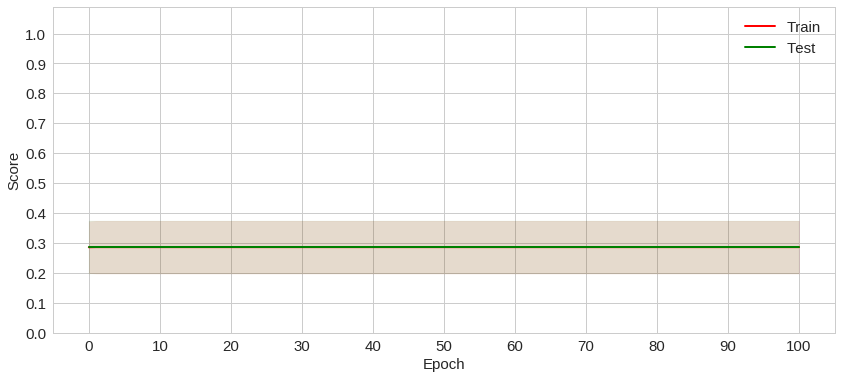

In [38]:
plot_mean_acc(tophist)

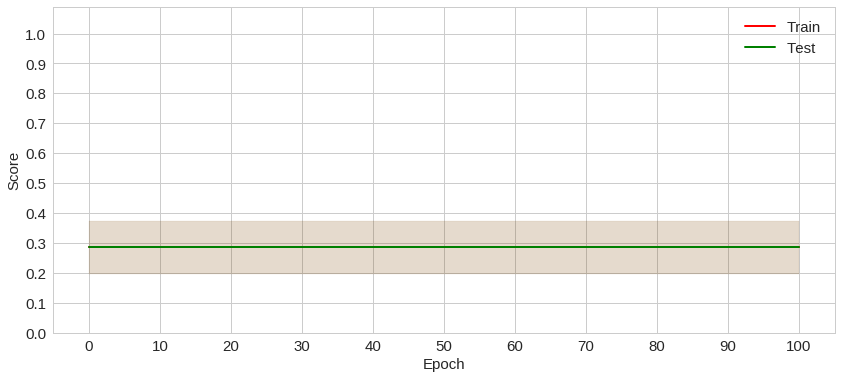

In [39]:
plot_mean_acc(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

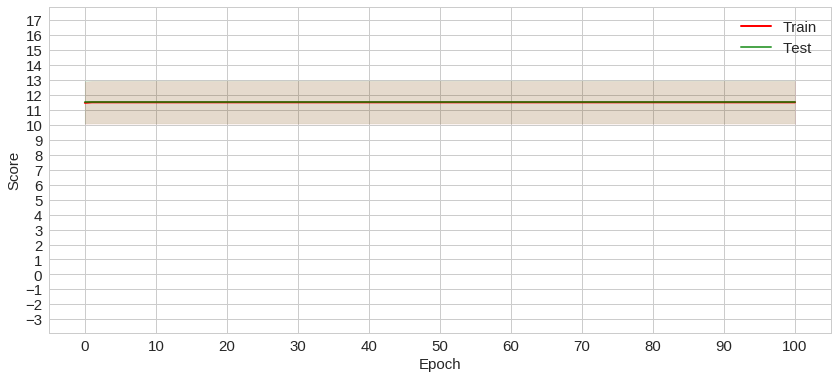

In [41]:
plot_mean_loss(tophist)

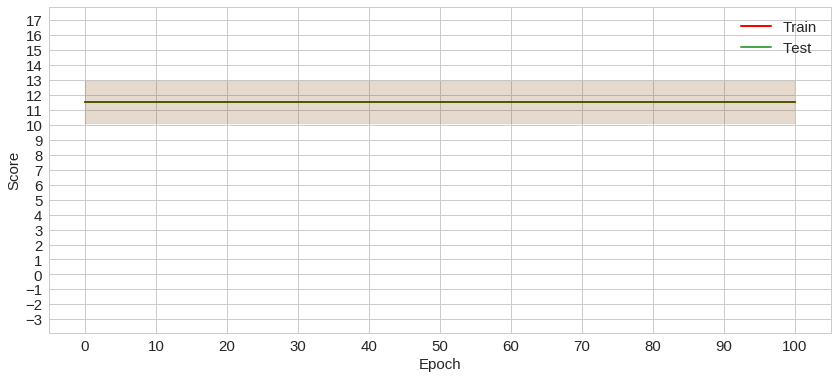

In [42]:
plot_mean_loss(hist)